In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import random

## 母集団（記事を読んだユーザの関心）データの作成

In [6]:
from make_pseudo_data import make_data

categories = ['economics', 'technology', 'sports']
probs = [0.5, 0.8, 0.2]

SIZE = 10000
data = make_data(probs, SIZE)
df = pd.DataFrame(data, columns=categories)
df.head()

,economics,technology,sports
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,0,1,0


## データのサンプリング

In [7]:
idx_all = range(SIZE)
idx = random.sample(idx_all, 10)
data[idx]

array([[0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 0],
       [0, 1, 0],
       [0, 1, 1],
       [1, 1, 0],
       [1, 1, 0],
       [1, 0, 0]])

### ベルヌーイモデル

In [8]:
def bernoulli_model(mu, lamb, obs):

    with pm.Model() as model:
        tau = pm.Exponential('tau', lamb)
        a = pm.Deterministic('a', 1 + tau * mu)
        b = pm.Deterministic('b', 1 + tau * (1 - mu))
        p = pm.Beta('p', alpha=a, beta=b)
        x = pm.Bernoulli('x', p=p, observed=obs)

    return model

In [9]:
# カテゴリの数だけモデルを作成．事前情報はなし
sample_size = 10
samples = data[random.sample(idx_all, sample_size)]
models = [bernoulli_model(mu=0.5, lamb=10., obs=obs) for obs in samples.T]
models

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2666' (I am process '5442')
WARNING (theano.gof.cmodule): Deleting (broken cache directory [EOF]): /home/user/.theano/compiledir_Linux-5.10-microsoft-standard-WSL2-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpdj6n1i2h


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5858.47draws/s]


prior	2000
posterior	2000


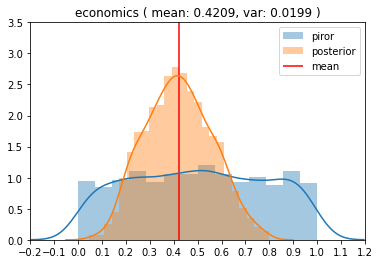

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [01:13<00:00, 54.59draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7183195378817826, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


prior	2000
posterior	2000


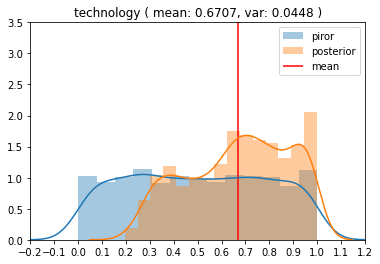

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5012.71draws/s]


prior	2000
posterior	2000


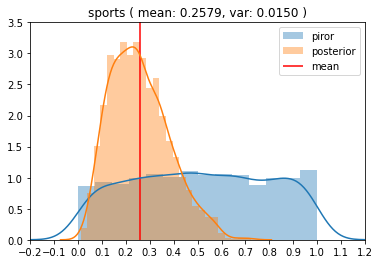

In [10]:
for categ, model in zip(categories, models):

    name = 'p'
    with model:
        prior = pm.sample_prior_predictive(samples=2000)
        posterior = pm.sample(draws=500, chains=4)

    print(f'prior\t{len(prior[name])}')
    print(f'posterior\t{len(posterior[name])}')

    plt.figure(figsize=(6, 4))

    sns.distplot(prior[name], label='piror')
    sns.distplot(posterior[name], label='posterior')
    plt.vlines([np.mean(posterior[name])], \
            ymin=0., ymax=3.5, colors='r', label='mean')
    plt.title(
        '{} ( mean: {:.4f}, var: {:.4f} )'\
        .format(categ, np.mean(posterior[name]), np.var(posterior[name]))
    )
    plt.xticks([0.1 * i for i in range(-2, 13)])
    plt.xlim(-0.2, 1.2)
    plt.ylim(0., 3.5)
    plt.legend()
    plt.show()

## 事前分布，事後分布のサンプリング

In [11]:
def update(models):

    prior_list, posterior_list = [], []
    for model in models:
        with model:
            prior = pm.sample_prior_predictive(samples=2000)
            posterior = pm.sample(draws=500, chains=4)
        prior_list.append(prior)
        posterior_list.append(posterior)

    return prior_list, posterior_list


## 閲覧数モデル

In [12]:
def exp_views(x, alpha, beta):
    return alpha * np.exp(- beta * x)

In [13]:
num_views = {}

### 人気記事

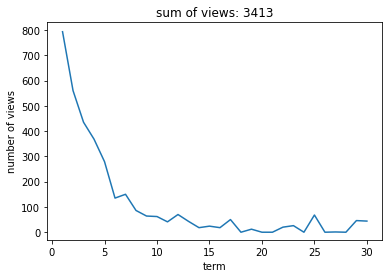

In [14]:
iters = 30
sigma = 30
x = np.arange(iters) + 1
np.random.seed(0)
eps = np.random.normal(0, sigma, iters)
y = (exp_views(x, alpha=1000, beta=0.3)  + eps).astype(int)
y = np.maximum(0, y)
num_views['large'] = y

plt.plot(x, y)
plt.ylim(-30, 830)
plt.xlabel('term')
plt.ylabel('number of views')
plt.title('sum of views: {}'.format(y.sum()))
plt.savefig('../figures/number_of_views_large.jpg')
plt.show()

### 閲覧数の少ない記事

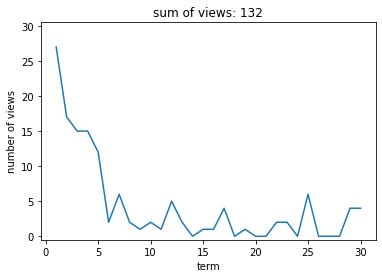

In [15]:
iters = 30
sigma = 3
x = np.arange(iters) + 1
np.random.seed(0)
eps = np.random.normal(0, sigma, iters)
y = (exp_views(x, alpha=30, beta=0.3)  + eps).astype(int)
y = np.maximum(0, y)
num_views['small'] = y

plt.plot(x, np.maximum(0, y))
plt.ylim(-0.5, 30.5)
plt.xlabel('term')
plt.ylabel('number of views')
plt.title('sum of views: {}'.format(y.sum()))
plt.savefig('../figures/number_of_views_small.jpg')
plt.show()

(-0.1, 1.1)

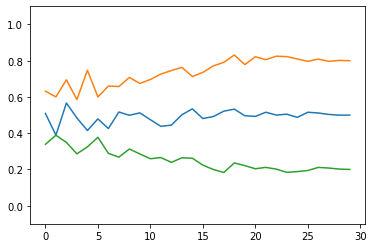

In [16]:
p_list = []
for i in range(30):
    eps = np.random.normal(0, (30 - i - 1) * 0.002, 3)
    
    probs = np.array([0.5, 0.8, 0.2])
    probs = probs + (0.5 - probs) * max(0, (20 - i - 1)) / 30 + eps
    probs = np.maximum(0, probs)
    probs = np.minimum(1, probs)
    p_list.append(probs.tolist())
p_list = np.array(p_list)
plt.plot(p_list[:, 0])
plt.plot(p_list[:, 1])
plt.plot(p_list[:, 2])
plt.ylim(-0.1, 1.1)

### 人気記事での実験

In [19]:
from IPython.display import clear_output

confidences = {categ: [0.5] for categ in categories}

SIZE = 10000
categories = ['economics', 'technology', 'sports']
lambdas = [max(np.exp(-0.3 * i)* 10, 0.1) for i in range(len(num_views['large']))]

for i, sample_size in enumerate(num_views['large']):
    if sample_size <= 0:
        continue

    np.random.seed(i)
    eps = np.random.normal(0, (30 - i - 1) * 0.002, 3)
    
    probs = np.array([0.5, 0.8, 0.2])
    probs = probs + (0.5 - probs) * max(0, (20 - i - 1)) / 30 + eps
    probs = np.maximum(0, probs)
    probs = np.minimum(1, probs)
    data = make_data(probs, SIZE)

    samples = data[random.sample(idx_all, sample_size)]
    models = [bernoulli_model(mu=confidences[categ][-1], lamb=lambdas[i], obs=obs) for categ, obs in zip(categories, samples.T)]
    prior_list, posterior_list = update(models)

    for j, categ in enumerate(categories):
        confidences[categ].append(np.mean(posterior_list[j]['p']))
        print(f'{categ}: {confidences[categ][-1]:.4f}')

    print('=' * 30)

clear_output()

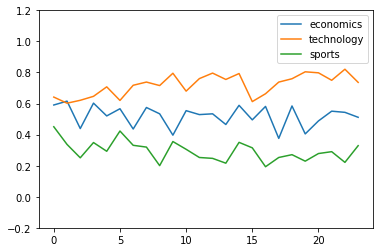

In [26]:
for key in confidences.keys():
    plt.plot(confidences[key][1:], label=key)
plt.ylim(-0.2, 1.2)
plt.legend()


### 閲覧数の少ない記事での実験

In [27]:
from IPython.display import clear_output

confidences = {categ: [0.5] for categ in categories}

SIZE = 10000
categories = ['economics', 'technology', 'sports']
lambdas = [max(np.exp(-0.3 * i)* 10, 0.1) for i in range(len(num_views['large']))]

for i, sample_size in enumerate(num_views['small']):
    if sample_size <= 0:
        continue

    np.random.seed(i)
    eps = np.random.normal(0, (30 - i - 1) * 0.002, 3)
    
    probs = np.array([0.5, 0.8, 0.2])
    probs = probs + (0.5 - probs) * max(0, (20 - i - 1)) / 30 + eps
    probs = np.maximum(0, probs)
    probs = np.minimum(1, probs)
    data = make_data(probs, SIZE)

    samples = data[random.sample(idx_all, sample_size)]
    models = [bernoulli_model(mu=confidences[categ][-1], lamb=lambdas[i], obs=obs) for categ, obs in zip(categories, samples.T)]
    prior_list, posterior_list = update(models)

    for j, categ in enumerate(categories):
        confidences[categ].append(np.mean(posterior_list[j]['p']))
        print(f'{categ}: {confidences[categ][-1]:.4f}')

    print('=' * 30)

clear_output()

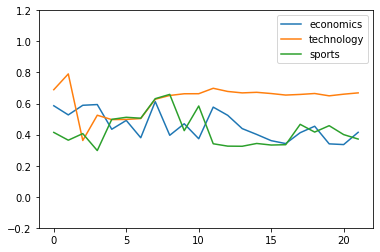

In [28]:
for key in confidences.keys():
    plt.plot(confidences[key][1:], label=key)
plt.ylim(-0.2, 1.2)
plt.legend()
